## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [3]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-08-16 17:11:56--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.243.134
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.243.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  72.7MB/s    in 4.7s    

2020-08-16 17:12:01 (69.1 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [4]:
# Import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# Import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# Watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [6]:
## Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=136, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.4)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# The dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# The transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


##Define the data_transform using transforms.Compose([all tx's, . , .])
# Order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

#Testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [8]:
# Create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

#Iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [9]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [10]:
# load in the test data, using the dataset class
# and apply the data_transform you defined above

# Create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [11]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [12]:
# Test the model on a batch of test images

def net_sample_output():
    
    # Iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # Get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # Convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # Forward pass to get net output
        output_pts = net(images)
        
        # Reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # Break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [13]:
# Call the above function
# Returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# Print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [14]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    #Image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    
    #Plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

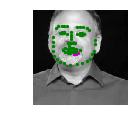

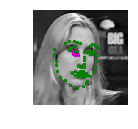

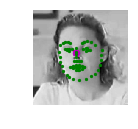

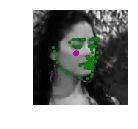

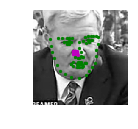

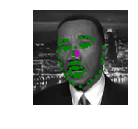

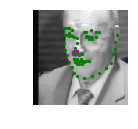

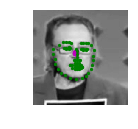

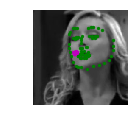

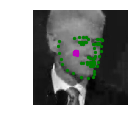

In [15]:
# Visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        #Un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        #Un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        #Undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        #Plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        #Call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
#Call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [16]:
##Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()


optimizer = optim.Adam(net.parameters(), lr=0.01)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [17]:
def train_net(n_epochs):

    #Prepare the net for training
    net.train()

    for epoch in range(n_epochs):  #Loop over the dataset multiple times
        
        running_loss = 0.0

        #Train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            #Get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            #Flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            #Convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            #Forward pass to get outputs
            output_pts = net(images)

            #Calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            #Zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            #Backward pass to calculate the weight gradients
            loss.backward()

            #Update the weights
            optimizer.step()

            #Print loss statistics
            running_loss += loss.item()
   
            
            if batch_i % 10 == 9:    # Print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [18]:
#Train your network
n_epochs = 10 # Start small, and increase when you've decided on your model structure and hyperparams

#This is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 203196.8421940744
Epoch: 1, Batch: 20, Avg. Loss: 0.3777918487787247
Epoch: 1, Batch: 30, Avg. Loss: 0.2465779885649681
Epoch: 1, Batch: 40, Avg. Loss: 0.22904159724712372
Epoch: 1, Batch: 50, Avg. Loss: 0.2072792246937752
Epoch: 1, Batch: 60, Avg. Loss: 0.17800151854753493
Epoch: 1, Batch: 70, Avg. Loss: 0.17673118636012078
Epoch: 1, Batch: 80, Avg. Loss: 0.22583454996347427
Epoch: 1, Batch: 90, Avg. Loss: 0.20092293620109558
Epoch: 1, Batch: 100, Avg. Loss: 0.2194536805152893
Epoch: 1, Batch: 110, Avg. Loss: 0.17933613210916519
Epoch: 1, Batch: 120, Avg. Loss: 0.18267025128006936
Epoch: 1, Batch: 130, Avg. Loss: 0.18976655676960946
Epoch: 1, Batch: 140, Avg. Loss: 0.154506815969944
Epoch: 1, Batch: 150, Avg. Loss: 0.1691509872674942
Epoch: 1, Batch: 160, Avg. Loss: 0.2451144903898239
Epoch: 1, Batch: 170, Avg. Loss: 0.20897379294037818
Epoch: 1, Batch: 180, Avg. Loss: 0.24700604677200316
Epoch: 1, Batch: 190, Avg. Loss: 0.27820242643356324
Epoch: 1, Ba

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.25400933921337127
Epoch: 2, Batch: 20, Avg. Loss: 0.21674806028604507
Epoch: 2, Batch: 30, Avg. Loss: 0.21060327515006066
Epoch: 2, Batch: 40, Avg. Loss: 0.16848216354846954
Epoch: 2, Batch: 50, Avg. Loss: 0.2794703096151352
Epoch: 2, Batch: 60, Avg. Loss: 0.2068656414747238
Epoch: 2, Batch: 70, Avg. Loss: 0.1911564737558365
Epoch: 2, Batch: 80, Avg. Loss: 0.21419651210308074
Epoch: 2, Batch: 90, Avg. Loss: 0.15730080008506775
Epoch: 2, Batch: 100, Avg. Loss: 0.18534304797649384
Epoch: 2, Batch: 110, Avg. Loss: 0.1911790743470192
Epoch: 2, Batch: 120, Avg. Loss: 0.18994910567998885
Epoch: 2, Batch: 130, Avg. Loss: 0.23980325162410737
Epoch: 2, Batch: 140, Avg. Loss: 0.17903690859675409
Epoch: 2, Batch: 150, Avg. Loss: 0.1747630186378956
Epoch: 2, Batch: 160, Avg. Loss: 0.20920463502407075
Epoch: 2, Batch: 170, Avg. Loss: 0.19170256927609444
Epoch: 2, Batch: 180, Avg. Loss: 0.21364689022302627
Epoch: 2, Batch: 190, Avg. Loss: 0.2355005070567131
Epoch: 2

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.15552012324333192
Epoch: 3, Batch: 20, Avg. Loss: 0.16350042894482614
Epoch: 3, Batch: 30, Avg. Loss: 0.2341054856777191
Epoch: 3, Batch: 40, Avg. Loss: 0.18824974745512008
Epoch: 3, Batch: 50, Avg. Loss: 0.18369442448019982
Epoch: 3, Batch: 60, Avg. Loss: 0.1947105623781681
Epoch: 3, Batch: 70, Avg. Loss: 0.2265065588057041
Epoch: 3, Batch: 80, Avg. Loss: 0.1899304859340191
Epoch: 3, Batch: 90, Avg. Loss: 0.17413340583443643
Epoch: 3, Batch: 100, Avg. Loss: 0.18161695152521135
Epoch: 3, Batch: 110, Avg. Loss: 0.19702815935015677
Epoch: 3, Batch: 120, Avg. Loss: 0.1680176191031933
Epoch: 3, Batch: 130, Avg. Loss: 0.1933129295706749
Epoch: 3, Batch: 140, Avg. Loss: 0.17566578835248947
Epoch: 3, Batch: 150, Avg. Loss: 0.22802407145500184
Epoch: 3, Batch: 160, Avg. Loss: 0.24916640669107437
Epoch: 3, Batch: 170, Avg. Loss: 0.2182910621166229
Epoch: 3, Batch: 180, Avg. Loss: 0.2301788344979286
Epoch: 3, Batch: 190, Avg. Loss: 0.17439666837453843
Epoch: 3, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.23751364946365355
Epoch: 4, Batch: 20, Avg. Loss: 0.18984558507800103
Epoch: 4, Batch: 30, Avg. Loss: 0.25108022764325144
Epoch: 4, Batch: 40, Avg. Loss: 0.1895918183028698
Epoch: 4, Batch: 50, Avg. Loss: 0.21084412932395935
Epoch: 4, Batch: 60, Avg. Loss: 0.17025112211704255
Epoch: 4, Batch: 70, Avg. Loss: 0.2031719595193863
Epoch: 4, Batch: 80, Avg. Loss: 0.16614442095160484
Epoch: 4, Batch: 90, Avg. Loss: 0.2056121289730072
Epoch: 4, Batch: 100, Avg. Loss: 0.17576347813010215
Epoch: 4, Batch: 110, Avg. Loss: 0.1679801344871521
Epoch: 4, Batch: 120, Avg. Loss: 0.21607281193137168
Epoch: 4, Batch: 130, Avg. Loss: 0.19440655559301376
Epoch: 4, Batch: 140, Avg. Loss: 0.18517367914319038
Epoch: 4, Batch: 150, Avg. Loss: 0.1960978887975216
Epoch: 4, Batch: 160, Avg. Loss: 0.2548606745898724
Epoch: 4, Batch: 170, Avg. Loss: 0.2016746371984482
Epoch: 4, Batch: 180, Avg. Loss: 0.19603359550237656
Epoch: 4, Batch: 190, Avg. Loss: 0.18242329061031343
Epoch: 4,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.15860305428504945
Epoch: 5, Batch: 20, Avg. Loss: 0.19424781054258347
Epoch: 5, Batch: 30, Avg. Loss: 0.21106230691075326
Epoch: 5, Batch: 40, Avg. Loss: 0.20682727843523024
Epoch: 5, Batch: 50, Avg. Loss: 0.1664645977318287
Epoch: 5, Batch: 60, Avg. Loss: 0.21255047619342804
Epoch: 5, Batch: 70, Avg. Loss: 0.22899039536714555
Epoch: 5, Batch: 80, Avg. Loss: 0.17636742070317268
Epoch: 5, Batch: 90, Avg. Loss: 0.18548817038536072
Epoch: 5, Batch: 100, Avg. Loss: 0.16888813376426698
Epoch: 5, Batch: 110, Avg. Loss: 0.19714313894510269
Epoch: 5, Batch: 120, Avg. Loss: 0.17419115528464318
Epoch: 5, Batch: 130, Avg. Loss: 0.18096525818109513
Epoch: 5, Batch: 140, Avg. Loss: 0.33532593920826914
Epoch: 5, Batch: 150, Avg. Loss: 0.2439032107591629
Epoch: 5, Batch: 160, Avg. Loss: 0.26146322339773176
Epoch: 5, Batch: 170, Avg. Loss: 0.16877079382538795
Epoch: 5, Batch: 180, Avg. Loss: 0.17359151020646096
Epoch: 5, Batch: 190, Avg. Loss: 0.18402712494134904
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.2534381628036499
Epoch: 6, Batch: 20, Avg. Loss: 0.15909861028194427
Epoch: 6, Batch: 30, Avg. Loss: 0.21023981794714927
Epoch: 6, Batch: 40, Avg. Loss: 0.15906242802739143
Epoch: 6, Batch: 50, Avg. Loss: 0.21977952420711516
Epoch: 6, Batch: 60, Avg. Loss: 0.24281870126724242
Epoch: 6, Batch: 70, Avg. Loss: 0.14621228575706482
Epoch: 6, Batch: 80, Avg. Loss: 0.21410185545682908
Epoch: 6, Batch: 90, Avg. Loss: 0.16563080623745918
Epoch: 6, Batch: 100, Avg. Loss: 0.17196900695562362
Epoch: 6, Batch: 110, Avg. Loss: 0.17472820430994035
Epoch: 6, Batch: 120, Avg. Loss: 0.2151003897190094
Epoch: 6, Batch: 130, Avg. Loss: 0.17281563505530356
Epoch: 6, Batch: 140, Avg. Loss: 0.171833349019289
Epoch: 6, Batch: 150, Avg. Loss: 0.19431009739637375
Epoch: 6, Batch: 160, Avg. Loss: 0.2390539526939392
Epoch: 6, Batch: 170, Avg. Loss: 0.17808681800961496
Epoch: 6, Batch: 180, Avg. Loss: 0.3188018620014191
Epoch: 6, Batch: 190, Avg. Loss: 0.23189124017953872
Epoch: 6

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.18977563604712486
Epoch: 7, Batch: 20, Avg. Loss: 0.22214789390563966
Epoch: 7, Batch: 30, Avg. Loss: 0.18282195776700974
Epoch: 7, Batch: 40, Avg. Loss: 0.3502885356545448
Epoch: 7, Batch: 50, Avg. Loss: 0.19981609731912614
Epoch: 7, Batch: 60, Avg. Loss: 0.23395478427410127
Epoch: 7, Batch: 70, Avg. Loss: 0.2094726175069809
Epoch: 7, Batch: 80, Avg. Loss: 0.16324993148446082
Epoch: 7, Batch: 90, Avg. Loss: 0.1848634250462055
Epoch: 7, Batch: 100, Avg. Loss: 0.1893201306462288
Epoch: 7, Batch: 110, Avg. Loss: 0.16654165238142013
Epoch: 7, Batch: 120, Avg. Loss: 0.20739784464240074
Epoch: 7, Batch: 130, Avg. Loss: 0.16557310670614242
Epoch: 7, Batch: 140, Avg. Loss: 0.19073452651500702
Epoch: 7, Batch: 150, Avg. Loss: 0.19595688432455063
Epoch: 7, Batch: 160, Avg. Loss: 0.19241665303707123
Epoch: 7, Batch: 170, Avg. Loss: 0.37216357216238977
Epoch: 7, Batch: 180, Avg. Loss: 0.1706514410674572
Epoch: 7, Batch: 190, Avg. Loss: 0.2085400827229023
Epoch: 7

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.20463876575231552
Epoch: 8, Batch: 20, Avg. Loss: 0.15327292904257775
Epoch: 8, Batch: 30, Avg. Loss: 0.22012279629707338
Epoch: 8, Batch: 40, Avg. Loss: 0.21825786903500558
Epoch: 8, Batch: 50, Avg. Loss: 0.2250427335500717
Epoch: 8, Batch: 60, Avg. Loss: 0.17184908241033553
Epoch: 8, Batch: 70, Avg. Loss: 0.1850394204258919
Epoch: 8, Batch: 80, Avg. Loss: 0.2624569371342659
Epoch: 8, Batch: 90, Avg. Loss: 0.22486478984355926
Epoch: 8, Batch: 100, Avg. Loss: 0.15940341353416443
Epoch: 8, Batch: 110, Avg. Loss: 0.1609663724899292
Epoch: 8, Batch: 120, Avg. Loss: 0.1831105776131153
Epoch: 8, Batch: 130, Avg. Loss: 0.2184774845838547
Epoch: 8, Batch: 140, Avg. Loss: 0.19302154183387757
Epoch: 8, Batch: 150, Avg. Loss: 0.1942300908267498
Epoch: 8, Batch: 160, Avg. Loss: 0.2363952785730362
Epoch: 8, Batch: 170, Avg. Loss: 0.22690674066543579
Epoch: 8, Batch: 180, Avg. Loss: 0.17905518412590027
Epoch: 8, Batch: 190, Avg. Loss: 0.18296483904123306
Epoch: 8, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.16217369288206102
Epoch: 9, Batch: 20, Avg. Loss: 0.21299923807382584
Epoch: 9, Batch: 30, Avg. Loss: 0.21683720797300338
Epoch: 9, Batch: 40, Avg. Loss: 0.16412933990359307
Epoch: 9, Batch: 50, Avg. Loss: 0.23099930435419083
Epoch: 9, Batch: 60, Avg. Loss: 0.2211811974644661
Epoch: 9, Batch: 70, Avg. Loss: 0.21945230662822723
Epoch: 9, Batch: 80, Avg. Loss: 0.21493018344044684
Epoch: 9, Batch: 90, Avg. Loss: 0.16587290912866592
Epoch: 9, Batch: 100, Avg. Loss: 0.1809376873075962
Epoch: 9, Batch: 110, Avg. Loss: 0.19331279247999192
Epoch: 9, Batch: 120, Avg. Loss: 0.19324709251523017
Epoch: 9, Batch: 130, Avg. Loss: 0.1824118010699749
Epoch: 9, Batch: 140, Avg. Loss: 0.18206156492233277
Epoch: 9, Batch: 150, Avg. Loss: 0.27030793875455855
Epoch: 9, Batch: 160, Avg. Loss: 0.2259323701262474
Epoch: 9, Batch: 170, Avg. Loss: 0.317718043923378
Epoch: 9, Batch: 180, Avg. Loss: 0.17430600225925447
Epoch: 9, Batch: 190, Avg. Loss: 0.2121427297592163
Epoch: 9,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.20279572606086732
Epoch: 10, Batch: 20, Avg. Loss: 0.22373195141553878
Epoch: 10, Batch: 30, Avg. Loss: 0.19893038272857666
Epoch: 10, Batch: 40, Avg. Loss: 0.15559555366635322
Epoch: 10, Batch: 50, Avg. Loss: 0.17154986038804054
Epoch: 10, Batch: 60, Avg. Loss: 0.16951244622468947
Epoch: 10, Batch: 70, Avg. Loss: 0.20399184301495552
Epoch: 10, Batch: 80, Avg. Loss: 0.2367773473262787
Epoch: 10, Batch: 90, Avg. Loss: 0.17322412133216858
Epoch: 10, Batch: 100, Avg. Loss: 0.24187029972672464
Epoch: 10, Batch: 110, Avg. Loss: 0.2045098677277565
Epoch: 10, Batch: 120, Avg. Loss: 0.22842805609107017
Epoch: 10, Batch: 130, Avg. Loss: 0.1707516834139824
Epoch: 10, Batch: 140, Avg. Loss: 0.2006494916975498
Epoch: 10, Batch: 150, Avg. Loss: 0.21762013509869577
Epoch: 10, Batch: 160, Avg. Loss: 0.2696995384991169
Epoch: 10, Batch: 170, Avg. Loss: 0.2298251748085022
Epoch: 10, Batch: 180, Avg. Loss: 0.28305028900504114
Epoch: 10, Batch: 190, Avg. Loss: 0.2043997

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [22]:
# Call the above function
# Returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

#Print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


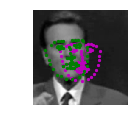

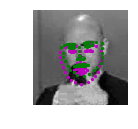

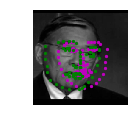

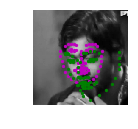

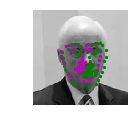

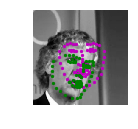

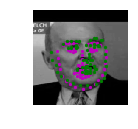

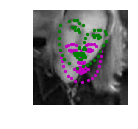

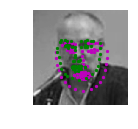

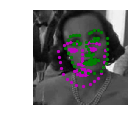

In [26]:
##Visualize your test output
#You can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [27]:
##Change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'facial_keypoints_model.pt'

#After training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I choose the MSELoss criterion and use the Adam optimization method. Since predicting facial keypoints is a regression task, the CrossEntropyLoss criterion which works well for calssification problem is not longer applicable. The MSELoss method measures the mean square error between each element and its target and determine how closed the element is toward the target. 

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: The network architecture consists of 4 convolution layers and each layer is activated by ReLu function and a max pooling method is applied after the activation step. The number of neurons in current layer is as twice as the previous layer and this criterion applies to all the convolution layers. Meanwhile both the width and height of kernel are decreased by 1 (e.g. kernel(5,5) for 1st layer, kernel(4,4) for 2nd layer, kernel(3,3) for 3rd layer etc). Becasue the size of images is decreasing as the convolution network process keeps moving on, it is racial to use a smaller size of kernel to capture more precise local features on the images. Furthermore, there are 1000 neurons to connect last convolution layer and the 1st full connected layer and there are 136 output channels after the 2nd full connected layer. The network archtecture is more clear as shown below:

conv1(1, 32, 5)

ReLu activiation

maxpool1(2, 2)

dropout1()

conv2(32, 64, 4)

ReLu activiation

maxpool2(2, 2)

dropout2()

conv3(64, 128, 3)

ReLu activiation

maxpool3(2, 2)

dropout3()

conv4(128 256, 2)

ReLu activiation

maxpool4(2, 2)

dropout4()


fc1(36864, 1000)


ReLu activation


fc2(1000, 136)

I only use 2 convolution layers firstly. However, the average loss is still too high after several iterations. Therefore, I decide to double the convolution layers to 4 and use dropout method to balance each neurons equally and avoid overfitting data in each layers, the average loss decreases and the result is acceptable. 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I try to use the default batch size (batch_size = 10) and the running time for each epochs is acceptable. However, the respone time increaes and sometimes the system stucks forever if I increase the batch size, therefore I just keep the batch size as default value. Meanwhile, I try to run 5 epochs firstly, and the running time is about 1 hour and the average loss seems to converge well, then I decide to run  10 epochs and see what happens. It takes 2-3 hours to run for 10 epochs and the average loss seems to converge better, therefore, I decide to run 10 epochs and keep the batch size as 10. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

(64, 32, 4, 4)
First convolutional layer


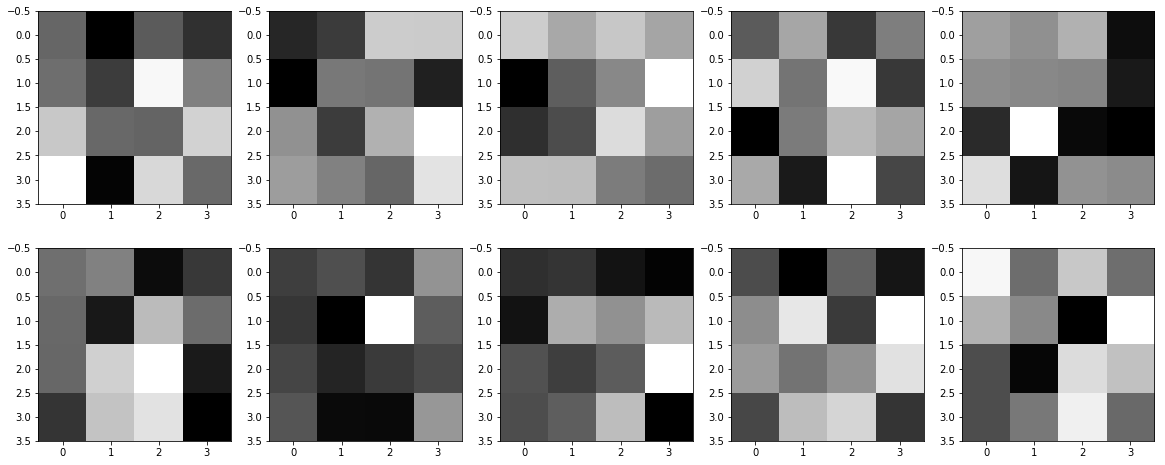

In [28]:
#Get the weights in the first conv layer, "conv1"
weights1 = net.conv2.weight.data
w = weights1.numpy()
print(w.shape)

#Load 10 filters
fig = plt.figure(figsize=(20, 8))
rows = 2
columns = 5

for i in range(0, rows*columns):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(w[i][0], cmap='gray')

print('First convolutional layer')
plt.show()


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

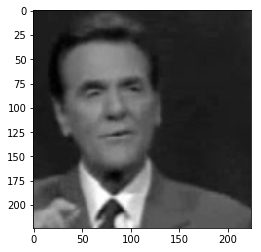

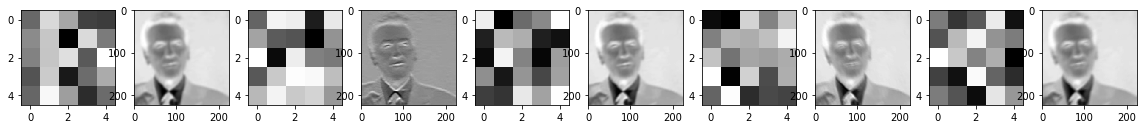

In [29]:
import cv2

idx = 0
img = test_images[idx].data   # Get the image from it's Variable wrapper
img = img.numpy()   # Convert to numpy array from a Tensor
img = np.transpose(img, (1, 2, 0))   # Transpose to go from torch to numpy image
plt.imshow(np.squeeze(img), cmap='gray')


weights = net.conv1.weight.data
w = weights.numpy()
fig=plt.figure(figsize=(20, 15))
rows = 1
columns = 10

for i in range(0, rows*columns):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The first filter starting on the left side has more grey and light grey grids on the left vertical size. It will capture more vertical edge features at the left side theoretically. When looking at the corresponding feature map, the outline of the person contains more vertical fetures, therefore it proves the thought.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!